In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
from itertools import chain
import warnings
warnings.filterwarnings("ignore")

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')


## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
12515,00003269_006.png,Infiltration,6,3269,16,M,AP,2896,2228,0.139,0.139,NaN
65926,00016291_010.png,No Finding,10,16291,53,M,PA,2992,2991,0.143,0.143,NaN
81434,00020014_000.png,Atelectasis,0,20014,59,F,PA,2992,2991,0.143,0.143,NaN


## One hot encoding of labels 

In [3]:
xray_df = pd.concat([all_xray_df, all_xray_df['Finding Labels'].str.get_dummies(sep="|")], 1)
xray_df = xray_df.drop(['Unnamed: 11'],1)
xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
25394,00006680_000.png,No Finding,0,6680,69,M,PA,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
85140,00020988_000.png,No Finding,0,20988,45,M,PA,3056,2532,0.139,...,0,0,0,0,0,1,0,0,0,0
105513,00028358_001.png,Infiltration,1,28358,63,M,PA,3056,2544,0.139,...,0,0,0,1,0,0,0,0,0,0


## Handling outliers and missing values if any

In [4]:
# Check for missing values
print('Number of missing values in the dataset: {}'.format(xray_df.isna().sum().sum()))

Number of missing values in the dataset: 0


In [5]:
# There are some outliers in the 'Patient Age' column 
# where the patient age is greater than 100 which is not very probable
print('Number of outlier records: {}'.format(len(xray_df[xray_df['Patient Age']>100])))

Number of outlier records: 16


In [6]:
# Deleting the oulier records, since we will not loose any significant information as
# as almost all the records have no sign of Pneumonia according to the Pneumonia label
xray_df.drop(xray_df[xray_df['Patient Age'] > 100].index, inplace=True)

In [7]:
xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0


## 1.  Visualizing patient demographics

### 1.a Patient Gender

In [8]:
actual_gender_count = ((xray_df[['Patient ID', 'Patient Gender']].drop_duplicates(subset=['Patient ID']))['Patient Gender']).value_counts()
total_gender_count = (xray_df['Patient Gender']).value_counts()


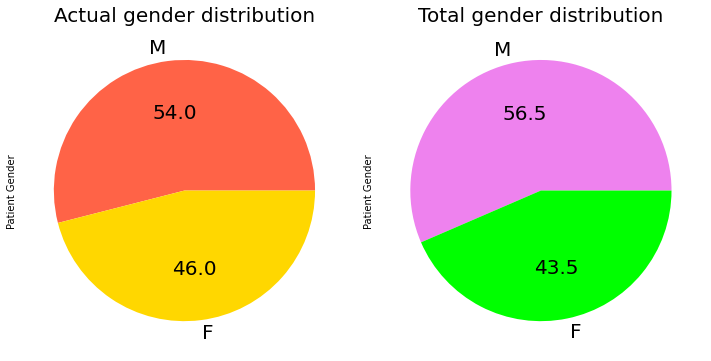

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

actual_gender_count.plot(kind='pie', autopct='%.1f', textprops={'fontsize': 20},
                                  colors=['tomato', 'gold', 'skyblue'], ax=ax1)
total_gender_count.plot(kind='pie', autopct='%.1f', textprops={'fontsize': 20},
                                 colors=['violet', 'lime'], ax=ax2)
ax1.set_title('Actual gender distribution', size=20)
ax2.set_title('Total gender distribution', size=20)
plt.tight_layout()
plt.show()

__Actual gender distribution :__ Gender distribution based on the number of distinct patients whose x-rays are recorded.

__Total gender distribution :__ Gender distribution based on all the records of all the patients (including their follow-ups)

Both the distributions are almost similar. To round up, it will be safe to say that __the dataset has approximately 45% of the records of Female patients while approximately 55% of the records of Male patients.__

### 1.b Patient Age

In [10]:
demographics = xray_df[['Patient ID', 'Patient Gender', 'Patient Age', 'View Position', 'Pneumonia']]
female_demographics = demographics[demographics['Patient Gender']=='F']['Patient Age']
male_demographics = demographics[demographics['Patient Gender']=='M']['Patient Age']

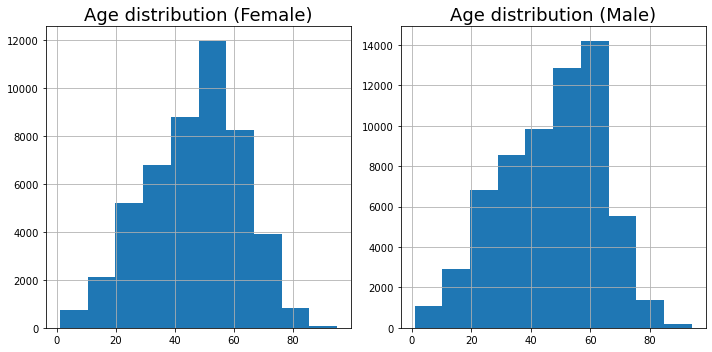

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
female_demographics.hist(ax=ax1)
male_demographics.hist(ax=ax2)
ax1.set_title('Age distribution (Female)', size=18)
ax2.set_title('Age distribution (Male)', size=18)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Age distribution')

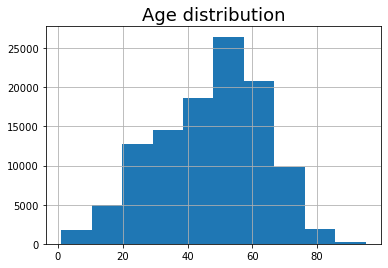

In [12]:
demographics['Patient Age'].hist()
plt.title('Age distribution', size=18)

From the above distribution plots, we can say that the age of the patients is normally distributed between age 1 to 90s where the __most__ of the patients appearing for the x-ray exams are between __40 - 70 years old for both men and women.__

### 1.c Postive cases of Pnuemonia among females 

In [13]:
female_demographics = demographics[(demographics['Patient Gender']=='F') & (demographics['Pneumonia']==1)]['Patient Age']
male_demographics = demographics[(demographics['Patient Gender']=='M') & (demographics['Pneumonia']==1)]['Patient Age']


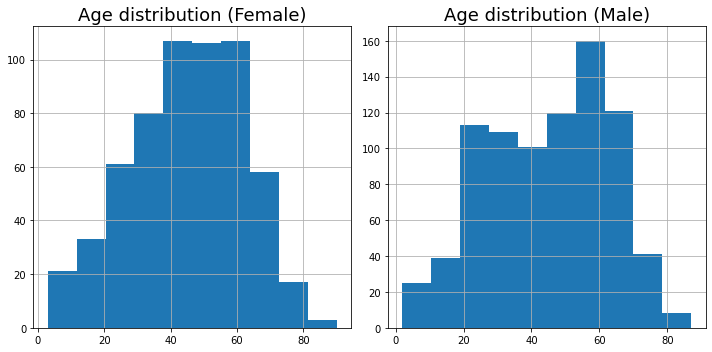

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
female_demographics.hist(ax=ax1)
male_demographics.hist(ax=ax2)
ax1.set_title('Age distribution (Female)', size=18)
ax2.set_title('Age distribution (Male)', size=18)
plt.tight_layout()
plt.show()

## 2. View position of X-rays

In [15]:
vp = demographics['View Position'].value_counts()
vp

PA    67299
AP    44805
Name: View Position, dtype: int64

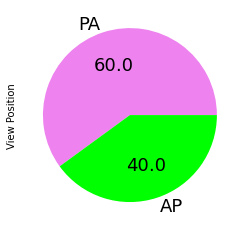

In [16]:
vp.plot(kind='pie', autopct='%.1f', textprops={'fontsize': 18},
                                 colors=['violet', 'lime'])

From the view position, it can be said that the around 40% of the time the patients are not able to stand erect for their chest x-ray exam while the other 60% of the time, the people are able. 

In short, in the dataset 40% of the patient records belong to the disable (temporarily or permanently) disabled patients where the radiologists are required to take Anterior Posterior radiographs while 60% of the patients are physically able to have the radiograph taken in an ieal position (PA) 

## 3. Explore distribution of disease in dataset

### 3.a Distribution of Pneumonia

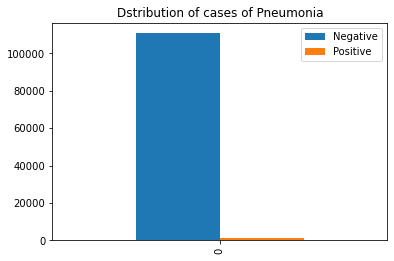

In [17]:
yes_pneumonia = len(xray_df[xray_df['Pneumonia']==1])
no_pneumonia = len(xray_df[xray_df['Pneumonia']==0])

data = [no_pneumonia, yes_pneumonia]
val = ['Negative','Positive']

df = pd.DataFrame(columns=val, data=[data])
df.plot(kind='bar')
plt.title('Dstribution of cases of Pneumonia')
plt.show()

In [18]:
xray_df['Pneumonia'].value_counts()

0    110674
1      1430
Name: Pneumonia, dtype: int64

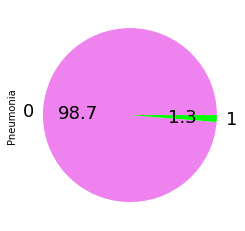

In [19]:
xray_df['Pneumonia'].value_counts().plot(kind='pie', autopct='%.1f', textprops={'fontsize': 18},
                                 colors=['violet', 'lime'])

__1.3% of the total cases are Pneumonia positive__ which is an extremely drastic imbalance in the distribution of the two classes. 

### 3.b Distribution of comorbidities with Pneumonia

In [20]:
# Filter the rows to include only those records where pneumonia is positive
comorbid = pd.concat([xray_df.iloc[:,11:], xray_df['Finding Labels']],1)
comorbid = comorbid[comorbid['Pneumonia']==1].drop(['No Finding'], axis=1)
comorbid

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Finding Labels
48,0,0,0,0,1,0,0,0,0,0,0,0,1,1,Effusion|Pneumonia|Pneumothorax
126,1,0,1,1,0,0,0,0,0,0,0,0,1,0,Atelectasis|Consolidation|Edema|Pneumonia
253,0,0,0,0,0,0,0,0,0,0,1,0,1,0,Nodule|Pneumonia
276,0,0,0,1,1,0,0,0,1,0,0,1,1,0,Edema|Effusion|Infiltration|Pleural_Thickening...
279,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111557,1,0,1,0,0,0,0,0,0,0,0,0,1,0,Atelectasis|Consolidation|Pneumonia
111627,0,0,0,1,0,0,0,0,1,0,0,0,1,0,Edema|Infiltration|Pneumonia
111767,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Pneumonia
111845,0,0,1,0,0,0,0,0,0,0,0,0,1,0,Consolidation|Pneumonia


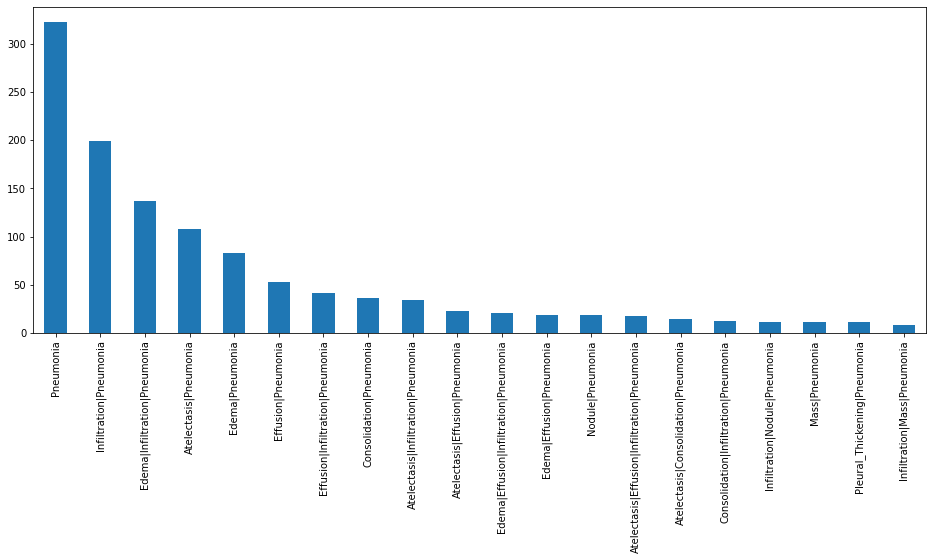

In [21]:
# Top 20 combinations of diseases that occur with pneumonia
plt.figure(figsize=(16,6))
comorbid['Finding Labels'].value_counts()[0:20].plot(kind='bar')

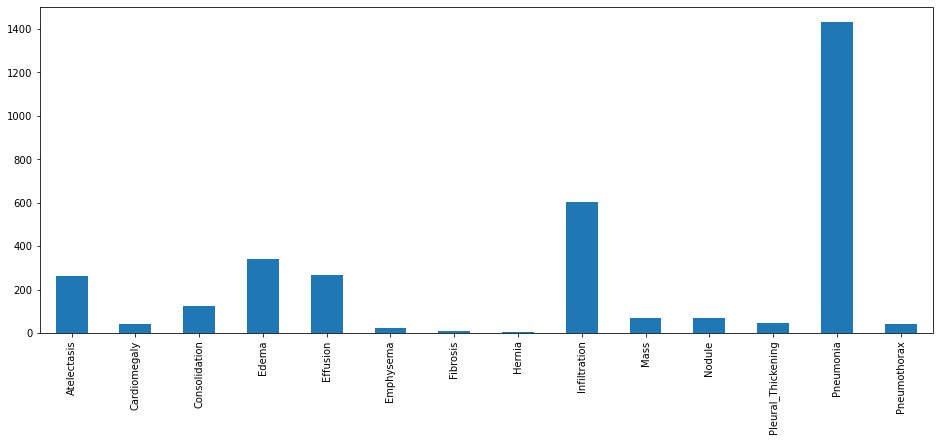

In [22]:
plt.figure(figsize=(16,6))
comorbid = comorbid.iloc[:,:-1]
comorbid.sum().plot(kind='bar')

Out of 1430 cases of Positive Pneumonia, Pneumonia alone occurs for less than 350 cases followed by the comorbidity with Infiltration. Infiltration also widely occurs in other combination of diseases that occur along with Pneumonia. 

After Infiltration, Edena and Atelectasis also contribute to the comorbidity in significant number of cases.

### 3.c Number of diseases diagnosed per exam 

Text(0, 0.5, 'Number of cases')

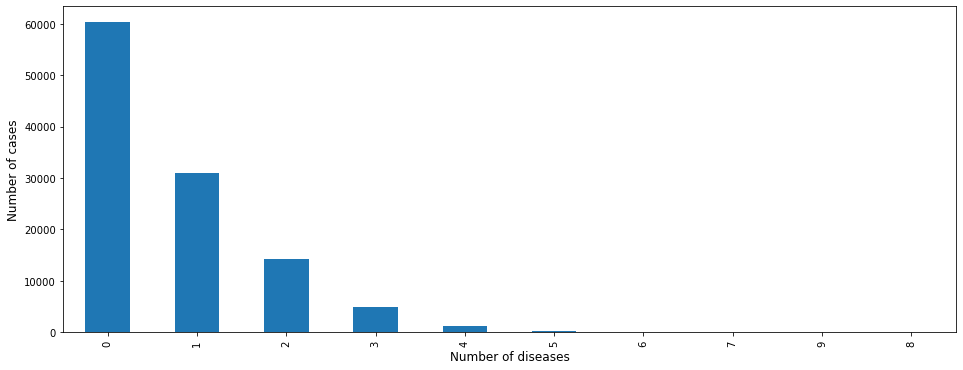

In [23]:
num_diseases = []
xray_df['Finding Labels'].map(lambda x: num_diseases.append(0) if x=='No Finding' else num_diseases.append(len(x.split("|"))))
num_diseases = pd.Series(num_diseases)
plt.figure(figsize=(16,6))
num_diseases.value_counts().plot(kind='bar')
plt.xlabel('Number of diseases',size=12)
plt.ylabel('Number of cases',size=12)

Approximately 60,000 cases results result in no finding of the disease while approx 30,000 cases report 1 disease followed by 15,000 cases with 2 diseases. 

### 3.d Number of diseases diagnosed per patient 

Text(0, 0.5, 'Number of cases')

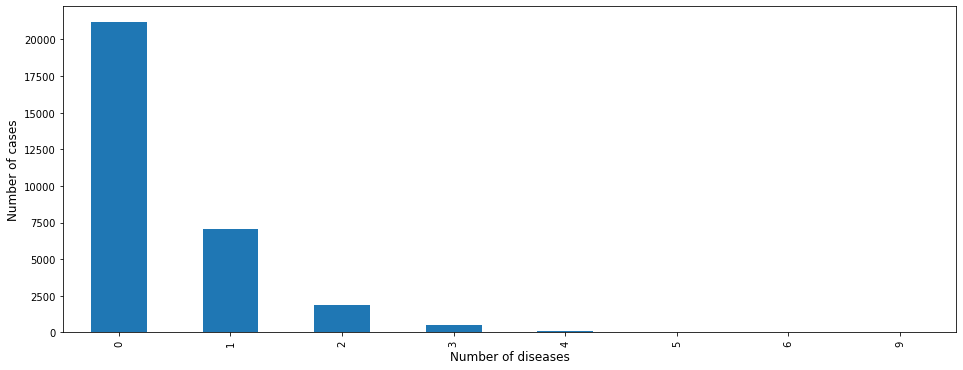

In [24]:
num_diseases = []
patient_df = xray_df.drop_duplicates(['Patient ID'])
patient_df['Finding Labels'].map(lambda x: num_diseases.append(0) if x=='No Finding' else num_diseases.append(len(x.split("|"))))
num_diseases = pd.Series(num_diseases)
plt.figure(figsize=(16,6))
num_diseases.value_counts().plot(kind='bar')
plt.xlabel('Number of diseases',size=12)
plt.ylabel('Number of cases',size=12)

Approximately 20,000 patients have no disease while approx 7,500 patients have 1 disease followed by 2,500 patients with 2 diseases. As the number of diseases increase, the likelihood of patients have those many diseases decreases.

## 4. Pixel level assessment

In [25]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}


In [26]:
healthy_image_path = '/data/images_012/images/00030805_000.png'
pneumonia_image_path = '/data/images_001/images/00000218_001.png'
infiltration_image_path = '/data/images_001/images/00000011_007.png'
atelectasis_image_path = '/data/images_012/images/00030780_000.png'

In [41]:
healthy = imread(healthy_image_path)
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

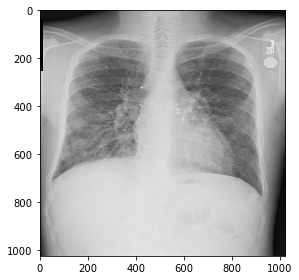

In [28]:
pneumonia = imread(pneumonia_image_path)
plt.figure()
imshow(pneumonia)

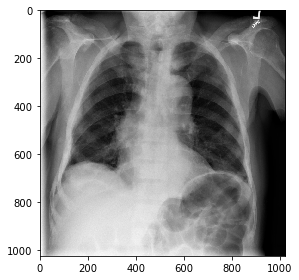

In [29]:
infiltration = imread(infiltration_image_path)
plt.figure()
imshow(infiltration)

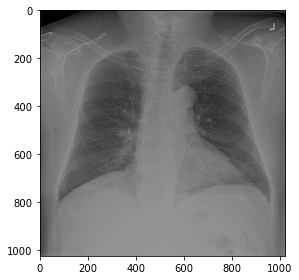

In [30]:
atelectasis = imread(atelectasis_image_path)
plt.figure()
imshow(atelectasis)

All the above images are shot in PA position, to maintain consistency.

Let's now see what the intensity plots of the images above reveal about them to find out if there is any clear-cut distinction between the plots. 

In [36]:
def intensity_normalization(image):
    '''
    Normalize the intensity plot of the image
    '''
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    new_img = image.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    return new_img

Text(0.5, 1.0, 'Atelectasis')

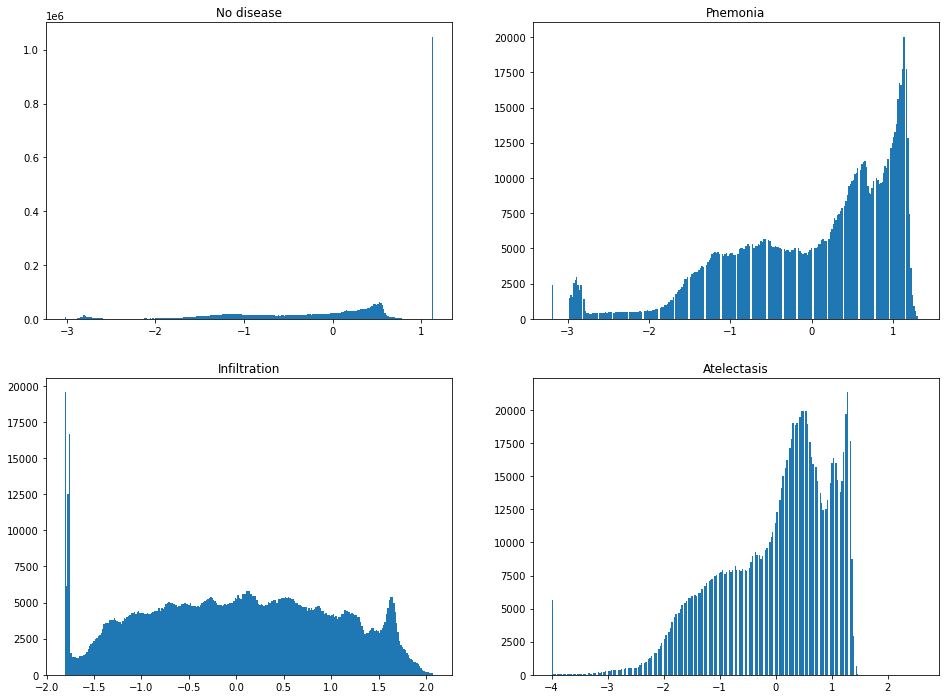

In [40]:
plt.figure(figsize=(16,12))

# Healthy histogram plot
plt.subplot(2,2,1)
plt.hist(intensity_normalization(healthy).ravel(), bins = 256)
plt.title('No disease')

# Pneumonia histogram plot
plt.subplot(2,2,2)
plt.hist(intensity_normalization(pneumonia).ravel(), bins = 256)
plt.title('Pneumonia')

# Infiltration histogram plot
plt.subplot(2,2,3)
plt.hist(intensity_normalization(infiltration).ravel(), bins = 256)
plt.title('Infiltration')

# Atelectasis histogram plot
plt.subplot(2,2,4)
plt.hist(intensity_normalization(atelectasis).ravel(), bins = 256)
plt.title('Atelectasis')

From the above normalized plots of various cases, it can be concluded that we can distinguish the nature of the disease from the intensity plot by using a threshold. The image with no disease has almost flat intensity distribution curve whereas the shape of the distribution curves for Pneumonia and Atelectasis is quite similar which points to the question for the domain experts that whetehr Atelectasis and Pneumonia has similar impact on lungs.  

For, the next steps, we will go towards building, training and testing CNN model. To build the model, the dataset split between train and test is very important. The EDA will help us decide how to split the train and test data. 

Since there are just 1.3% of the positive cases for Pneumonia and the rest 98.7% of the dataset has no cases for Pneumonia. We will make sure when we split the dataset, we have equal distribution of positive and negative samples in both train and test. 

For the demographics data distribution, from the above graphs, it can be said that the gender and age distribution is equivalent. Also, we have almost equal contribution of AP and PA postions in the dataset. Therefore, while we are splitting data based on Positive and Negative Pneumonia sample, we will keep in mind that the datasets have equal contributions of Age, gender and view positions. 